In [3]:
import numpy as np
import openslide
from openslide import deepzoom
import matplotlib.pyplot as plt
import random
import utility_functions as uf
import torch
import os
from PIL import Image
import xlrd
import time
import imageio
import skimage
import skimage.io
import skimage.transform

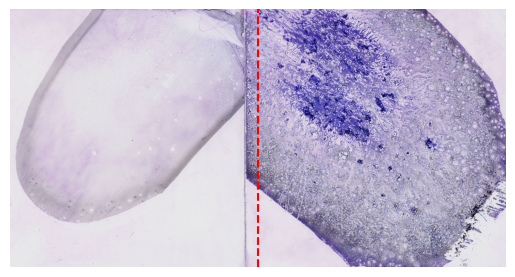

In [2]:
slide_num = 1027
left_proportion = 0.5
slidePath = "/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num)
slide = openslide.open_slide(slidePath)
simg = np.array(slide.get_thumbnail((2000, 2000)))
# Remove the coordinate axis
plt.axis('off')
plt.imshow(simg)
#plot a line seperating right and left with a proportion 0.65
plt.axvline(x=2000*left_proportion, color='r', linestyle='--')
plt.savefig("../imgs/{}_with_red_line.png".format(slide_num))

In [3]:
with openslide.OpenSlide(slidePath) as slide:
  print(slide.level_count) # 幾種分辨率
  # print(slide.dimensions) #最高分辨率下的(width, height)
  print(slide.level_dimensions) #所有分辨率的(width,height)
  # print(slide.level_downsamples) # 每個分辨的倍數關係，即level_dimension[k] = dimensions / level_downsamples[k]

9
((90112, 46848), (45056, 23424), (22528, 11712), (11264, 5856), (5632, 2928), (2816, 1464), (1408, 732), (704, 366), (352, 183))


<Figure size 6400x4800 with 0 Axes>

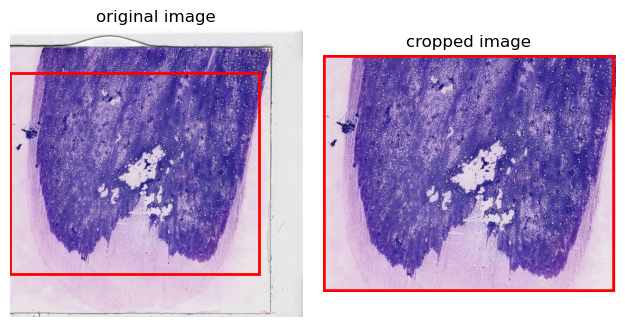

In [4]:
slide_level = 6 # 0 ~ 9
with openslide.OpenSlide(slidePath) as slide:
  # 切出切出右側的圖片
  dims = slide.level_dimensions
  level_dim = list(dims[slide_level])
  level_dim[0] = int(level_dim[0]*(1-left_proportion))
  split_x =int(dims[0][0]*left_proportion)
  level6_img_RGB = slide.read_region((split_x,0),slide_level,level_dim).convert("RGB")
  #save image as new png file
  # level6_img_RGB.save("split_slide.png")
  # 讀入原始圖片
  image = level6_img_RGB
  # 取得原始圖片的寬度和高度
  width, height = image.size
  # 計算要裁剪的區域
  shrink_proportion = 0.15
  left = int(width * 0)
  right = int(width *(1-shrink_proportion))
  top = int(height * shrink_proportion)
  bottom = int(height * (1-shrink_proportion))
  # 進行裁剪
  cropped_image = image.crop((left, top, right, bottom))
  # 保存裁剪後的圖片
  # cropped_image.save('cropped_image.jpg')
  # 顯示裁剪前與後的圖片
  simg = np.array(level6_img_RGB)
  simg2 = np.array(cropped_image)
  # 設定子圖
  fig = plt.figure(dpi = 1000)
  fig, axes = plt.subplots(nrows=1, ncols=2)
  # 在第一個子圖中顯示第一張圖片
  axes[0].imshow(simg)
  axes[0].set_title('original image')
  # 在第二個子圖中顯示第二張圖片
  axes[1].imshow(simg2)
  axes[1].set_title('cropped image')
  #圖片顯示不要座標
  axes[0].set_xticks([])
  axes[0].set_yticks([])
  axes[1].set_xticks([])
  axes[1].set_yticks([])
  # 在圖片上標註出裁剪的區域
  axes[0].add_patch(plt.Rectangle((left, top), right - left, bottom - top, fill=False, edgecolor='red', linewidth=2))
  plt.tight_layout()
  #第一個子圖不要外匡
  axes[0].spines['top'].set_visible(False)
  axes[0].spines['right'].set_visible(False)
  axes[0].spines['bottom'].set_visible(False)
  axes[0].spines['left'].set_visible(False)
  #第二個子圖不要外匡
  axes[1].spines['top'].set_visible(False)
  axes[1].spines['right'].set_visible(False)
  axes[1].spines['bottom'].set_visible(False)
  axes[1].spines['left'].set_visible(False)
  #第二張圖片紅色外匡
  axes[1].add_patch(plt.Rectangle((0, 0), right - left, bottom - top, fill=False, edgecolor='red', linewidth=4))
  # 儲存圖片
  plt.savefig('/home/weber50432/AML_image_processing/imgs/cropped_image.png')
  # 顯示圖片窗口
  plt.show()



In [5]:
with openslide.OpenSlide(slidePath) as slide:
  print(slide.dimensions) #最高分辨率下的(width, height)

(212992, 104448)


# check training data (WSI)

/home/exon_storage1/aml_slide/renameByUPN/A13.ndpi
the number of patches are: 250
[(141824, 51712), (133376, 40192), (138752, 41472), (165376, 83200), (138752, 37120), (160768, 31744), (152064, 67072), (161280, 65024), (153344, 59904), (135680, 17408)]


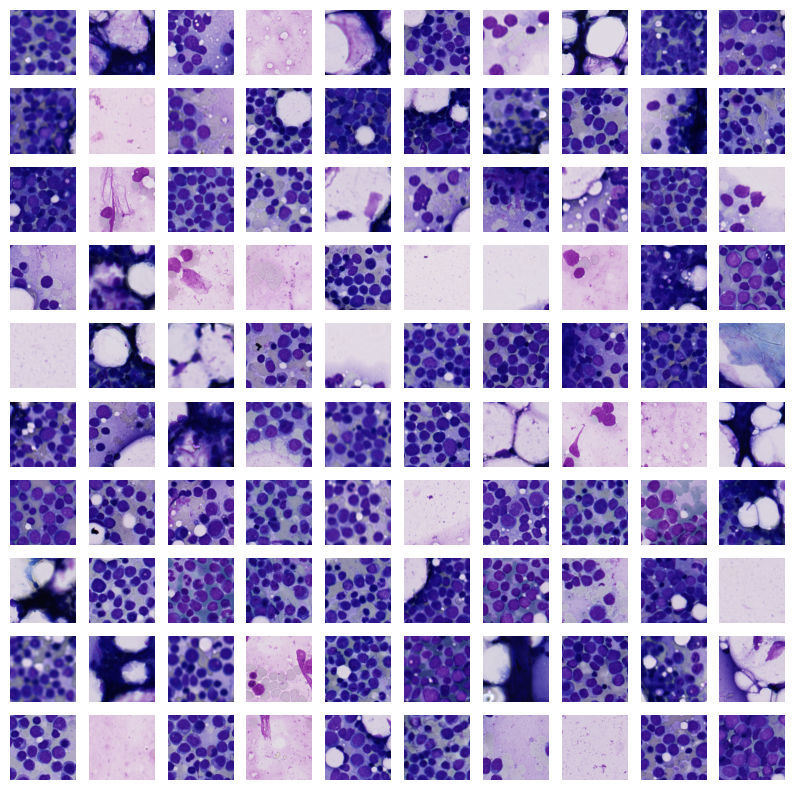

In [6]:
gene = "ITD"
slide_num1 = 3 # 0 for random
lib_train = torch.load("/home/weber50432/AML_image_processing/lib/{}/{}_train_data.pt".format(gene,gene))
if slide_num1 == 0:
    index = random.randint(0,len(lib_train["slides"]))
else:
    index = lib_train["slides"].index( "/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num1))
patch_list = lib_train["grid"][index]
print(lib_train["slides"][index])
print("the number of patches are:",len(patch_list))
output_unit = 10
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:output_unit])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
with openslide.OpenSlide(slidePath) as slide:
    for i in random_patch:
        sig = slide.read_region(i, 0, (256, 256))
        axarr[int(k/output_unit),k%output_unit].imshow(sig)
        k += 1

# check validation data (WSI)

/home/exon_storage1/aml_slide/renameByUPN/A833.ndpi
[(155392, 23808), (140800, 15360), (164096, 27648), (168448, 45824), (155648, 62976)]
the number of patches are: 250


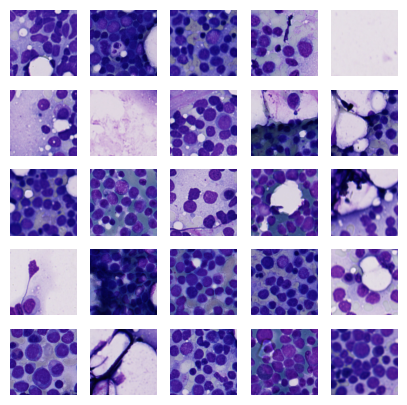

In [7]:
gene = "ITD"
slide_num2 = 0 # 0 for random
lib_val = torch.load("/home/weber50432/AML_image_processing/lib/{}/{}_val_data.pt".format(gene,gene))
if slide_num2 == 0:
    index = random.randint(0,len(lib_val["slides"]))
else:
    index = lib_val["slides"].index("/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num2))
patch_list = lib_val["grid"][index]
print(lib_val["slides"][index])
output_unit = 5
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:output_unit])
print("the number of patches are:",len(patch_list))
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
with openslide.OpenSlide(slidePath) as slide:
    for i in random_patch:
        sig = slide.read_region(i, 0, (256, 256))
        axarr[int(k/output_unit),k%output_unit].imshow(sig)
        k += 1

# check test data(WSI)

/home/exon_storage1/aml_slide/renameByUPN/A983.ndpi
the number of patches are: 250
[(156928, 56576), (124416, 49408), (154112, 62976), (110592, 24576), (130048, 79104)]


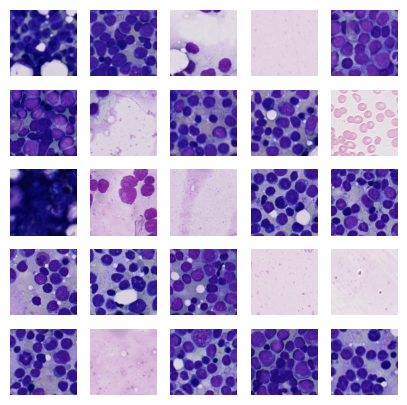

In [8]:
gene = "ITD"
slide_num3 = 0 # 0 for random
lib_test = torch.load("/home/weber50432/AML_image_processing/lib/{}/{}_test_data.pt".format(gene,gene))
if slide_num3 == 0:
    index = random.randint(0,len(lib_test["slides"]))
else:
    index = lib_test["slides"].index("/home/exon_storage1/aml_slide/renameByUPN/A{}.ndpi".format(slide_num3))
patch_list = lib_test["grid"][index]
print(lib_test["slides"][index])
print("the number of patches are:",len(patch_list))
output_unit = 5
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:5])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
with openslide.OpenSlide(slidePath) as slide:
    for i in random_patch:
        sig = slide.read_region(i, 0, (256, 256))
        axarr[int(k/output_unit),k%output_unit].imshow(sig)
        k += 1

# check patches by a given number

the number of patches are: 2147
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_37713.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_25422.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_32631.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_19271.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_27910.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_31558.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_19347.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_25084.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_24727.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_22871.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_19628.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_37621.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A3_49225.png
/home/exon_storage1/aml_slide/patches/A3/rightside_patch/A

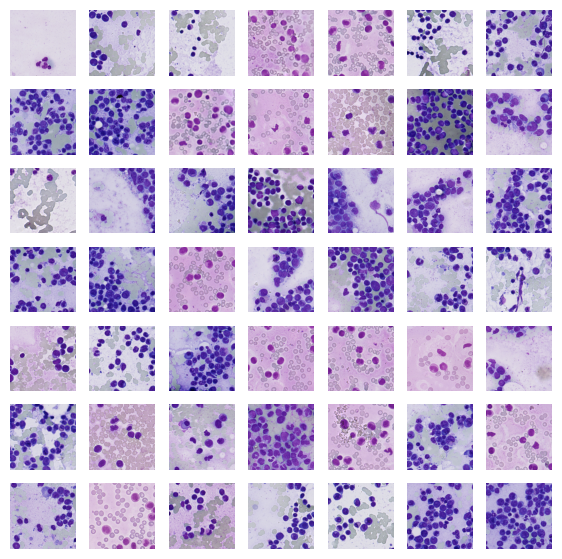

In [8]:
slide_num = 3
directory_path = '/home/weber50432/AML_image_processing/HCT_region_select/output/A{}/'.format(slide_num)
exel_source = directory_path + 'porduction_result.xls'
wb = xlrd.open_workbook(exel_source)
sheet = wb.sheet_by_index(0)
patch_list = sheet.col_values(0)
patch_list.pop(0)
print("the number of patches are:",len(patch_list))
output_unit = 7
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
# print(random_patch[:output_unit])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
for i in random_patch:
    # img_path = os.path.join(directory_path,i)
    sig = Image.open(i)
    print(i)
    # sig.resize((224,224),Image.BILINEAR)
    axarr[int(k/output_unit),k%output_unit].imshow(sig)
    k += 1

# check data (patches)

Selecting 100 patches from the total 500 patches
['/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_39895.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_35629.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_46927.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_35230.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_41481.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_41909.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_70408.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_19106.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_28158.png', '/home/exon_storage1/aml_slide/patches/A13/rightside_patch/A13_28566.png']


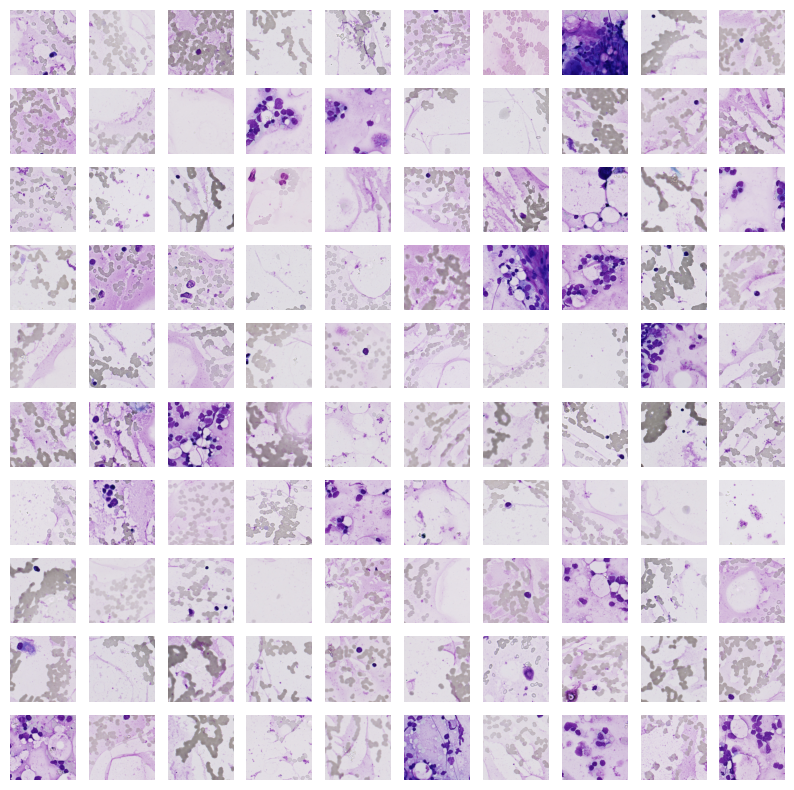

In [3]:
lib = torch.load("/home/weber50432/AML_image_processing/lib/NPM1_patch_test/NPM1_patch_test_train_data.pt")
# index = random.randint(0,len(lib["slides"])-1)
index = 3
patch_list = lib["grid"][index]
output_unit = 10
print("Selecting {} patches from the total {} patches".format(output_unit*output_unit,len(patch_list)))
# patch_list = uf.get_grid("/home/exon_storage1/aml_slide/",[413],256,0.65,0.15)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:output_unit])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(output_unit,output_unit))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
for i in random_patch:
    # img_path = os.path.join(directory_path,i)
    sig = Image.open(i)
    # sig.resize((224,224),Image.BILINEAR)
    axarr[int(k/output_unit),k%output_unit].imshow(sig)
    k += 1

/tmp/ipykernel_1685876/1736357167.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(image_path)


<Figure size 6400x4800 with 0 Axes>

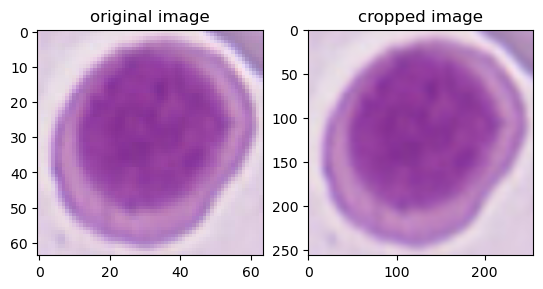

In [10]:

def load_image_fov(path, crop_size=512):
    # load image
    resized_img=None
    if os.path.getsize(path)>5000:
        img = skimage.io.imread(path)
        img = img / 255.0
        assert (0 <= img).all() and (img <= 1.0).all()
        # print "Original Image Shape: ", img.shape
        # we crop image from center
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
        # resize to 224, 224
        resized_img = skimage.transform.resize(crop_img, (crop_size, crop_size))
    #except OSError as e:
        #print('Could not read:', path, ':', e, '- it\'s ok, skipping.')
        #pass
        
    return resized_img
image_path ="/home/weber50432/AML_image_processing/HCT_cell_detection/A3_31145/Erythroblast/A3_31145_9.png"
image = load_image_fov(image_path,128)
# Load the TIFF image using imageio
original_image = imageio.imread(image_path)
# Display the image and the original image
fig = plt.figure(dpi = 1000)
fig, axes = plt.subplots(nrows=1, ncols=2)
# 在第一個子圖中顯示第一張圖片
axes[0].imshow(original_image)
axes[0].set_title('original image')
# 在第二個子圖中顯示第二張圖片
axes[1].imshow(image)
axes[1].set_title('cropped image')
# 顯示圖片
plt.show()

['FieldPos257_EDOF_RGB.tiff', 'FieldPos212_EDOF_RGB.tiff', 'FieldPos231_EDOF_RGB.tiff', 'FieldPos182_EDOF_RGB.tiff']


/tmp/ipykernel_1334183/1468209368.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sig = imageio.imread(file_path+i)


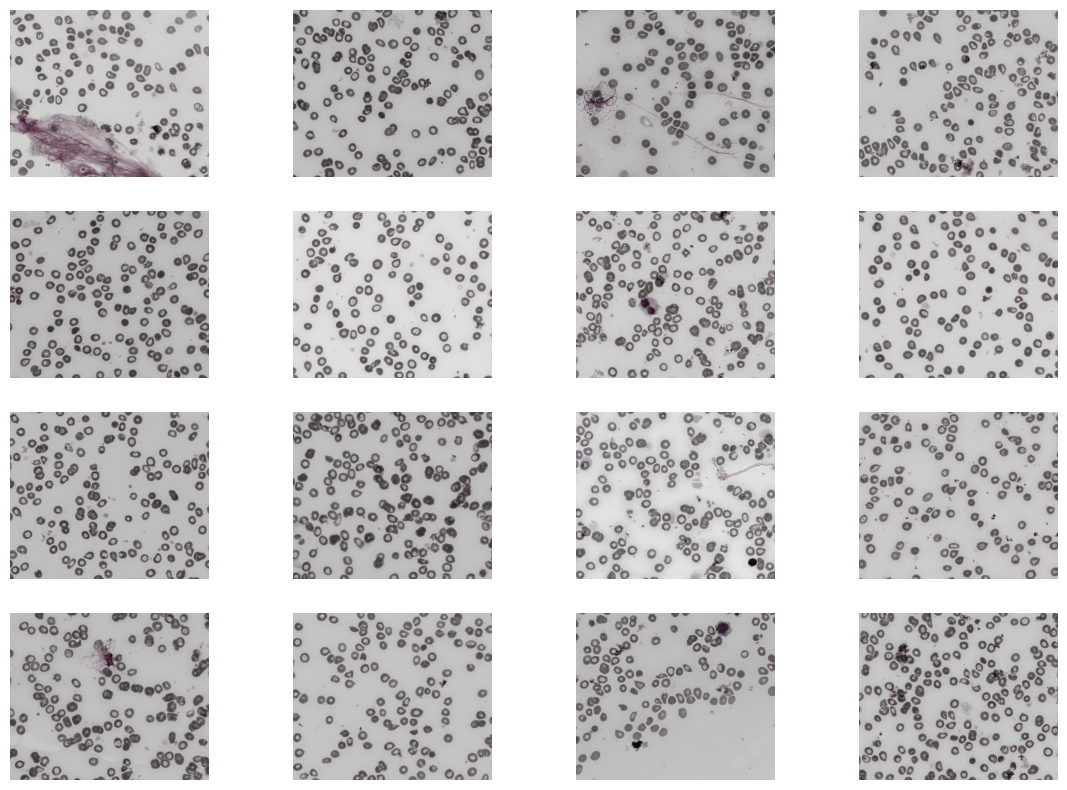

In [13]:
output_unit = 4
file_path = "/home/weber50432/AML_image_processing/FASt-MAL-MOFF-master/data/sickle-edofed/010319-05r1-S-A-S1-20190816160305/"
patch_list = []
for filename in os.listdir(file_path):
    if filename.endswith(".tiff") or filename.endswith(".png"):    
        patch_list.append(filename)
random_patch = random.sample(patch_list, output_unit*output_unit)
print(random_patch[:output_unit])
f, axarr = plt.subplots(output_unit, output_unit , sharex=True, sharey=True,figsize=(7*2,5*2))
for ax in axarr.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
k = 0
for i in random_patch:
    # img_path = os.path.join(directory_path,i)
    sig = imageio.imread(file_path+i)
    # sig.resize((224,224),Image.BILINEAR)
    axarr[int(k/output_unit),k%output_unit].imshow(sig)
    k += 1